<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/model-classification/Classify_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-05-30_30_double_to

## Import packages

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## Get data at pattern for training & testing

In [4]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,11.210000,11.310000,11.350000,11.410000,11.450000,11.450000,11.400000,11.320000,11.200000,11.270000,11.380000,11.450000,11.290000,11.370000,11.240000,11.180000,11.120000,11.200000,11.230000,11.180000,11.020000,11.010000,11.030000,11.100000,11.180000,11.260000,11.080000,11.040000,10.950000,10.790000,10.800000
1,43.849998,43.900002,44.750000,44.349998,44.660000,44.849998,45.770000,45.509998,45.990002,45.490002,45.090000,45.099998,45.549999,45.560001,45.439999,44.990002,45.000000,45.060001,45.060001,44.630001,45.160000,44.889999,44.590000,44.770000,45.560001,44.900002,44.669998,44.880001,44.689999,44.310001,44.570000
2,32.180000,31.780001,32.340000,32.740002,32.619999,32.150002,32.029999,32.500000,32.650002,32.520000,32.150002,32.480000,32.549999,32.380001,32.980000,32.799999,32.540001,32.380001,32.080002,32.119999,32.750000,33.419998,32.619999,32.200001,32.560001,32.419998,32.040001,32.330002,32.200001,31.530001,31.580000
3,14.150000,13.010000,12.420000,12.310000,11.900000,10.720000,10.610000,12.580000,12.330000,12.630000,12.660000,12.250000,12.000000,12.030000,11.970000,12.070000,15.280000,14.750000,14.310000,14.600000,15.000000,15.000000,14.980000,14.970000,14.990000,14.990000,15.060000,15.000000,14.450000,14.000000,13.250000
4,19.000000,19.250000,19.250000,19.049999,19.299999,19.150000,18.799999,18.850000,18.600000,18.549999,18.799999,18.549999,18.500000,18.500000,18.600000,18.650000,18.850000,18.750000,18.750000,18.650000,19.299999,19.450001,19.250000,18.950001,19.200001,19.049999,19.100000,19.000000,18.600000,18.400000,18.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,41.869999,43.299999,43.310001,43.150002,43.820000,44.369999,44.220001,45.820000,45.439999,45.380001,45.720001,45.040001,46.130001,44.660000,44.869999,44.680000,44.099998,43.630001,43.619999,43.750000,43.980000,44.410000,44.680000,45.240002,45.230000,45.070000,44.389999,44.580002,44.459999,43.529999,43.570000
9975,39.090000,39.599998,39.430000,39.650002,40.709999,40.009998,39.939999,39.320000,38.650002,38.250000,39.290001,38.820000,38.939999,38.529999,39.779999,40.139999,39.950001,39.990002,39.740002,39.430000,39.330002,39.279999,39.139999,39.349998,42.669998,43.419998,42.279999,42.709999,43.080002,42.209999,41.900002
9976,42.389999,41.919998,42.099998,41.169998,41.590000,41.630001,41.680000,41.790001,41.450001,41.230000,42.400002,42.369999,42.169998,41.990002,41.810001,41.730000,42.110001,41.970001,41.849998,42.130001,42.049999,42.459999,43.299999,43.200001,42.950001,42.500000,42.400002,41.520000,41.389999,40.689999,40.099998
9977,118.209999,118.519997,116.000000,117.459999,116.970001,117.620003,118.110001,118.250000,116.849998,117.529999,116.820000,116.050003,115.589996,115.800003,115.269997,115.449997,115.459999,115.669998,116.239998,116.139999,118.610001,116.949997,117.230003,119.970001,119.809998,117.209999,120.330002,119.180000,117.250000,115.989998,117.320000


In [5]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.05 #@param {type:"number"}

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        y_val = a * x_data[i] + b
        err = abs(y_val - y_data[i])
        if (err > trend_delta * y_val):
            b_is_trend = False
            break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [6]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
min_height = 0.5 #@param {type:"number"}

In [7]:
def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_tops = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [8]:
def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [9]:
for i, row in price_patterns_df.iterrows():
    double_tops = find_double_top(range(len(row)), row.to_numpy())
    double_bots = find_double_bottom(range(len(row)), row.to_numpy())
    print(i, double_tops, double_bots)

Streaming output truncated to the last 5000 lines.
4979 [(18, 22, 24, 26, 29)] []
4980 [(16, 19, 21, 24, 25)] []
4981 [(23, 26, 27, 28, 29)] [(22, 23, 26, 27, 28)]
4982 [(16, 18, 22, 24, 29)] []
4983 [(11, 12, 14, 16, 17)] [(9, 11, 12, 14, 16)]
4984 [(20, 23, 25, 26, 27), (20, 26, 27, 28, 29)] []
4985 [(1, 3, 4, 5, 6), (15, 16, 18, 21, 22), (15, 17, 18, 21, 22), (24, 25, 26, 28, 29)] [(23, 24, 25, 26, 28), (23, 24, 25, 27, 28)]
4986 [(21, 23, 24, 25, 29)] []
4987 [] []
4988 [(4, 7, 9, 11, 13), (4, 7, 13, 20, 29), (4, 11, 13, 18, 29), (4, 11, 13, 20, 29), (15, 20, 22, 27, 29)] [(7, 9, 11, 13, 20)]
4989 [] []
4990 [(6, 9, 10, 16, 24)] []
4991 [(7, 14, 17, 20, 27), (7, 14, 17, 23, 27)] []
4992 [] []
4993 [(11, 16, 21, 26, 29), (11, 16, 21, 28, 29), (11, 18, 21, 26, 29), (11, 19, 21, 26, 29)] [(2, 3, 4, 9, 12), (2, 3, 4, 11, 12)]
4994 [(21, 22, 24, 27, 29)] [(18, 19, 20, 21, 22)]
4995 [] [(12, 15, 16, 18, 22)]
4996 [] []
4997 [(19, 22, 24, 25, 29)] []
4998 [(17, 20, 21, 24, 29)] []
4999 [(

In [10]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

              0           1           2   ...          27          28          29
0      11.210000   11.310000   11.350000  ...   11.040000   10.950000   10.790000
1      43.849998   43.900002   44.750000  ...   44.880001   44.689999   44.310001
2      32.180000   31.780001   32.340000  ...   32.330002   32.200001   31.530001
3      14.150000   13.010000   12.420000  ...   15.000000   14.450000   14.000000
4      19.000000   19.250000   19.250000  ...   19.000000   18.600000   18.400000
...          ...         ...         ...  ...         ...         ...         ...
9974   41.869999   43.299999   43.310001  ...   44.580002   44.459999   43.529999
9975   39.090000   39.599998   39.430000  ...   42.709999   43.080002   42.209999
9976   42.389999   41.919998   42.099998  ...   41.520000   41.389999   40.689999
9977  118.209999  118.519997  116.000000  ...  119.180000  117.250000  115.989998
9978   22.879999   21.620001   22.230000  ...   21.570000   21.799999   20.860001

[9979 rows x 30

In [11]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

def y_preice_to_y_label(X, y, min_change=0):
    assert len(X) == len(y)
    n = len(y)
    y_label = np.array([get_direction(X[i][-1], y[i], min_change) for i in range(n)])
    # Convert from {-1; 0; 1} to label {0; 1; 2}
    y_label = y_label + 1
    return y_label

In [12]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]
min_price_change = 0 #@param {type:"number"}

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_ratio, random_state=7)
# X_train, y_train = X_data[: n_train], y_data[: n_train]
y_train_label = y_preice_to_y_label(X_train, y_train, min_price_change)
y_train_categorical = to_categorical(y_train_label, num_classes=3)
# X_test, y_test = X_data[n_train:], y_data[n_train:]
y_test_label = y_preice_to_y_label(X_test, y_test, min_price_change)
y_test_categorical = to_categorical(y_test_label, num_classes=3)
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    y_train_scaled_label = y_preice_to_y_label(X_train_scaled, y_train_scaled, min_price_change)
    y_train_scaled_categorical = to_categorical(y_train_scaled_label, num_classes=3)
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    y_test_scaled_label = y_preice_to_y_label(X_test_scaled, y_test_scaled, min_price_change)
    y_test_scaled_categorical = to_categorical(y_test_scaled_label, num_classes=3)
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(y_train_categorical.shape)
print(y_train_scaled_categorical.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)
print(y_test_categorical.shape)
print(y_test_scaled_categorical.shape)

# print(X_train)
# print(y_train)

(7983, 30) (7983, 1)
(7983, 30) (7983, 1)
(7983, 3)
(7983, 3)
(1996, 30) (1996, 1)
(1996, 30) (1996, 1)
(1996, 3)
(1996, 3)


## LSTM model

### Build model

In [ ]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 10000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/10000
1/1 [==============================] - 30s 30s/step - loss: 1.1014 - accuracy: 0.2929 - val_loss: 1.0885 - val_accuracy: 0.5040

Epoch 00001: val_accuracy improved from -inf to 0.50401, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2/10000
1/1 [==============================] - 0s 348ms/step - loss: 1.0889 - accuracy: 0.5004 - val_loss: 1.0756 - val_accuracy: 0.5140

Epoch 00002: val_accuracy improved from 0.50401 to 0.51403, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 3/10000
1/1 [==============================] - 0s 299ms/step - loss: 1.0757 - accuracy: 0.5013 - val_loss: 1.0582 - val_accuracy: 0.5060

Epoch 00003: val_accuracy did not improve from 0.51403
Epoch 4/10000
1/1 [==============================] - 0s 311ms/step - loss: 1.0591 - accuracy: 0.5018 - val_loss: 1.0347 - val_accuracy: 0.4965

Epoch 00004: val_accuracy did not improve from 0.51403
Epoch 5/10000
1/1 [==============================] - 0s 271ms/step - loss: 1.0374 - accuracy: 0.4935 - val_loss: 1.0037 - val_accuracy: 0.4965

Epoch 00005: val_accuracy did not improve from 0.51403
Epoch 6/10000
1/1 [==============================] - 0s 266ms/step - loss: 1.0076 - accuracy: 0.5006 - val_loss: 0.9636 - val_accuracy: 0.4965

Epoch 00006: val_accuracy did not improve from 0.51403
Epoch 7/10000
1/1 [==============================] - 0s 267ms/step - loss: 0.9701 - accuracy: 0.4962 - val_loss: 0.9147 - val_accuracy: 0.4965

Epoch 00007: val_accuracy did not improve from 0.51403
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 527/10000
1/1 [==============================] - 0s 361ms/step - loss: 0.6935 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5035

Epoch 00527: val_accuracy did not improve from 0.51854
Epoch 528/10000
1/1 [==============================] - 0s 307ms/step - loss: 0.6935 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5035

Epoch 00528: val_accuracy did not improve from 0.51854
Epoch 529/10000
1/1 [==============================] - 0s 279ms/step - loss: 0.6935 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5035

Epoch 00529: val_accuracy did not improve from 0.51854
Epoch 530/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6932 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5035

Epoch 00530: val_accuracy did not improve from 0.51854
Epoch 531/10000
1/1 [==============================] - 0s 272ms/step - loss: 0.6934 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.5035

Epoch 00531: val_accuracy did not improve from 0.5

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1129/10000
1/1 [==============================] - 0s 360ms/step - loss: 0.6928 - accuracy: 0.5120 - val_loss: 0.6928 - val_accuracy: 0.5170

Epoch 01129: val_accuracy did not improve from 0.51904
Epoch 1130/10000
1/1 [==============================] - 0s 296ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6928 - val_accuracy: 0.5120

Epoch 01130: val_accuracy did not improve from 0.51904
Epoch 1131/10000
1/1 [==============================] - 0s 286ms/step - loss: 0.6933 - accuracy: 0.5048 - val_loss: 0.6928 - val_accuracy: 0.5140

Epoch 01131: val_accuracy did not improve from 0.51904
Epoch 1132/10000
1/1 [==============================] - 0s 303ms/step - loss: 0.6933 - accuracy: 0.5077 - val_loss: 0.6927 - val_accuracy: 0.5120

Epoch 01132: val_accuracy did not improve from 0.51904
Epoch 1133/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6929 - accuracy: 0.5065 - val_loss: 0.6928 - val_accuracy: 0.5110

Epoch 01133: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1142/10000
1/1 [==============================] - 0s 273ms/step - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6928 - val_accuracy: 0.5135

Epoch 01142: val_accuracy did not improve from 0.52054
Epoch 1143/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6937 - accuracy: 0.4927 - val_loss: 0.6929 - val_accuracy: 0.5105

Epoch 01143: val_accuracy did not improve from 0.52054
Epoch 1144/10000
1/1 [==============================] - 0s 265ms/step - loss: 0.6936 - accuracy: 0.4994 - val_loss: 0.6930 - val_accuracy: 0.5055

Epoch 01144: val_accuracy did not improve from 0.52054
Epoch 1145/10000
1/1 [==============================] - 0s 269ms/step - loss: 0.6932 - accuracy: 0.5102 - val_loss: 0.6930 - val_accuracy: 0.5055

Epoch 01145: val_accuracy did not improve from 0.52054
Epoch 1146/10000
1/1 [==============================] - 0s 270ms/step - loss: 0.6934 - accuracy: 0.5032 - val_loss: 0.6929 - val_accuracy: 0.5125

Epoch 01146: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1219/10000
1/1 [==============================] - 0s 344ms/step - loss: 0.6929 - accuracy: 0.5053 - val_loss: 0.6923 - val_accuracy: 0.5240

Epoch 01219: val_accuracy did not improve from 0.52455
Epoch 1220/10000
1/1 [==============================] - 0s 308ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6924 - val_accuracy: 0.5185

Epoch 01220: val_accuracy did not improve from 0.52455
Epoch 1221/10000
1/1 [==============================] - 0s 279ms/step - loss: 0.6928 - accuracy: 0.5068 - val_loss: 0.6924 - val_accuracy: 0.5160

Epoch 01221: val_accuracy did not improve from 0.52455
Epoch 1222/10000
1/1 [==============================] - 0s 276ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6924 - val_accuracy: 0.5165

Epoch 01222: val_accuracy did not improve from 0.52455
Epoch 1223/10000
1/1 [==============================] - 0s 276ms/step - loss: 0.6930 - accuracy: 0.5112 - val_loss: 0.6924 - val_accuracy: 0.5215

Epoch 01223: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1235/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6930 - accuracy: 0.4983 - val_loss: 0.6922 - val_accuracy: 0.5160

Epoch 01235: val_accuracy did not improve from 0.52505
Epoch 1236/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.6928 - accuracy: 0.5130 - val_loss: 0.6923 - val_accuracy: 0.5155

Epoch 01236: val_accuracy did not improve from 0.52505
Epoch 1237/10000
1/1 [==============================] - 0s 268ms/step - loss: 0.6931 - accuracy: 0.5078 - val_loss: 0.6922 - val_accuracy: 0.5175

Epoch 01237: val_accuracy did not improve from 0.52505
Epoch 1238/10000
1/1 [==============================] - 0s 301ms/step - loss: 0.6925 - accuracy: 0.5125 - val_loss: 0.6922 - val_accuracy: 0.5200

Epoch 01238: val_accuracy did not improve from 0.52505
Epoch 1239/10000
1/1 [==============================] - 0s 272ms/step - loss: 0.6927 - accuracy: 0.5122 - val_loss: 0.6921 - val_accuracy: 0.5266

Epoch 01239: val_accuracy improved from 0.525

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1240/10000
1/1 [==============================] - 0s 356ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6921 - val_accuracy: 0.5180

Epoch 01240: val_accuracy did not improve from 0.52655
Epoch 1241/10000
1/1 [==============================] - 0s 297ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6923 - val_accuracy: 0.5130

Epoch 01241: val_accuracy did not improve from 0.52655
Epoch 1242/10000
1/1 [==============================] - 0s 272ms/step - loss: 0.6930 - accuracy: 0.5046 - val_loss: 0.6923 - val_accuracy: 0.5135

Epoch 01242: val_accuracy did not improve from 0.52655
Epoch 1243/10000
1/1 [==============================] - 0s 273ms/step - loss: 0.6931 - accuracy: 0.5106 - val_loss: 0.6922 - val_accuracy: 0.5185

Epoch 01243: val_accuracy did not improve from 0.52655
Epoch 1244/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6928 - accuracy: 0.5131 - val_loss: 0.6922 - val_accuracy: 0.5205

Epoch 01244: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1317/10000
1/1 [==============================] - 0s 364ms/step - loss: 0.6926 - accuracy: 0.5070 - val_loss: 0.6920 - val_accuracy: 0.5145

Epoch 01317: val_accuracy did not improve from 0.52705
Epoch 1318/10000
1/1 [==============================] - 0s 296ms/step - loss: 0.6926 - accuracy: 0.5098 - val_loss: 0.6921 - val_accuracy: 0.5115

Epoch 01318: val_accuracy did not improve from 0.52705
Epoch 1319/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6929 - accuracy: 0.5128 - val_loss: 0.6921 - val_accuracy: 0.5115

Epoch 01319: val_accuracy did not improve from 0.52705
Epoch 1320/10000
1/1 [==============================] - 0s 284ms/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6920 - val_accuracy: 0.5180

Epoch 01320: val_accuracy did not improve from 0.52705
Epoch 1321/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.6928 - accuracy: 0.5130 - val_loss: 0.6921 - val_accuracy: 0.5296

Epoch 01321: val_accuracy improved from 0.527

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1322/10000
1/1 [==============================] - 0s 270ms/step - loss: 0.6927 - accuracy: 0.5161 - val_loss: 0.6921 - val_accuracy: 0.5105

Epoch 01322: val_accuracy did not improve from 0.52956
Epoch 1323/10000
1/1 [==============================] - 0s 273ms/step - loss: 0.6925 - accuracy: 0.5105 - val_loss: 0.6922 - val_accuracy: 0.5135

Epoch 01323: val_accuracy did not improve from 0.52956
Epoch 1324/10000
1/1 [==============================] - 0s 272ms/step - loss: 0.6928 - accuracy: 0.5103 - val_loss: 0.6922 - val_accuracy: 0.5120

Epoch 01324: val_accuracy did not improve from 0.52956
Epoch 1325/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.6927 - accuracy: 0.5090 - val_loss: 0.6920 - val_accuracy: 0.5075

Epoch 01325: val_accuracy did not improve from 0.52956
Epoch 1326/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6930 - accuracy: 0.5028 - val_loss: 0.6919 - val_accuracy: 0.5210

Epoch 01326: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2213/10000
1/1 [==============================] - 0s 358ms/step - loss: 0.6918 - accuracy: 0.5148 - val_loss: 0.6916 - val_accuracy: 0.5286

Epoch 02213: val_accuracy did not improve from 0.53056
Epoch 2214/10000
1/1 [==============================] - 0s 300ms/step - loss: 0.6919 - accuracy: 0.5166 - val_loss: 0.6917 - val_accuracy: 0.5261

Epoch 02214: val_accuracy did not improve from 0.53056
Epoch 2215/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.6919 - accuracy: 0.5167 - val_loss: 0.6915 - val_accuracy: 0.5210

Epoch 02215: val_accuracy did not improve from 0.53056
Epoch 2216/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.6920 - accuracy: 0.5101 - val_loss: 0.6909 - val_accuracy: 0.5200

Epoch 02216: val_accuracy did not improve from 0.53056
Epoch 2217/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.6917 - accuracy: 0.5126 - val_loss: 0.6910 - val_accuracy: 0.5205

Epoch 02217: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2886/10000
1/1 [==============================] - 0s 360ms/step - loss: 0.6820 - accuracy: 0.5547 - val_loss: 0.6964 - val_accuracy: 0.5266

Epoch 02886: val_accuracy did not improve from 0.53206
Epoch 2887/10000
1/1 [==============================] - 0s 308ms/step - loss: 0.6811 - accuracy: 0.5578 - val_loss: 0.6971 - val_accuracy: 0.5286

Epoch 02887: val_accuracy did not improve from 0.53206
Epoch 2888/10000
1/1 [==============================] - 0s 273ms/step - loss: 0.6804 - accuracy: 0.5574 - val_loss: 0.6970 - val_accuracy: 0.5321

Epoch 02888: val_accuracy did not improve from 0.53206
Epoch 2889/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.6807 - accuracy: 0.5588 - val_loss: 0.6972 - val_accuracy: 0.5291

Epoch 02889: val_accuracy did not improve from 0.53206
Epoch 2890/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.6832 - accuracy: 0.5613 - val_loss: 0.6959 - val_accuracy: 0.5276

Epoch 02890: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2894/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6804 - accuracy: 0.5582 - val_loss: 0.6956 - val_accuracy: 0.5261

Epoch 02894: val_accuracy did not improve from 0.53507
Epoch 2895/10000
1/1 [==============================] - 0s 268ms/step - loss: 0.6808 - accuracy: 0.5561 - val_loss: 0.6958 - val_accuracy: 0.5225

Epoch 02895: val_accuracy did not improve from 0.53507
Epoch 2896/10000
1/1 [==============================] - 0s 276ms/step - loss: 0.6805 - accuracy: 0.5608 - val_loss: 0.6966 - val_accuracy: 0.5215

Epoch 02896: val_accuracy did not improve from 0.53507
Epoch 2897/10000
1/1 [==============================] - 0s 268ms/step - loss: 0.6785 - accuracy: 0.5633 - val_loss: 0.6972 - val_accuracy: 0.5200

Epoch 02897: val_accuracy did not improve from 0.53507
Epoch 2898/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.6808 - accuracy: 0.5582 - val_loss: 0.6987 - val_accuracy: 0.5256

Epoch 02898: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4101/10000
1/1 [==============================] - 0s 364ms/step - loss: 0.5374 - accuracy: 0.7024 - val_loss: 0.8979 - val_accuracy: 0.5235

Epoch 04101: val_accuracy did not improve from 0.53607
Epoch 4102/10000
1/1 [==============================] - 0s 306ms/step - loss: 0.5502 - accuracy: 0.6906 - val_loss: 0.8976 - val_accuracy: 0.5235

Epoch 04102: val_accuracy did not improve from 0.53607
Epoch 4103/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.5379 - accuracy: 0.7070 - val_loss: 0.8895 - val_accuracy: 0.5291

Epoch 04103: val_accuracy did not improve from 0.53607
Epoch 4104/10000
1/1 [==============================] - 0s 279ms/step - loss: 0.5447 - accuracy: 0.6937 - val_loss: 0.8836 - val_accuracy: 0.5311

Epoch 04104: val_accuracy did not improve from 0.53607
Epoch 4105/10000
1/1 [==============================] - 0s 286ms/step - loss: 0.5390 - accuracy: 0.6981 - val_loss: 0.8916 - val_accuracy: 0.5230

Epoch 04105: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4246/10000
1/1 [==============================] - 0s 361ms/step - loss: 0.5237 - accuracy: 0.7110 - val_loss: 0.9259 - val_accuracy: 0.5281

Epoch 04246: val_accuracy did not improve from 0.53657
Epoch 4247/10000
1/1 [==============================] - 0s 303ms/step - loss: 0.5292 - accuracy: 0.7049 - val_loss: 0.9260 - val_accuracy: 0.5316

Epoch 04247: val_accuracy did not improve from 0.53657
Epoch 4248/10000
1/1 [==============================] - 0s 279ms/step - loss: 0.5243 - accuracy: 0.7135 - val_loss: 0.9213 - val_accuracy: 0.5396

Epoch 04248: val_accuracy improved from 0.53657 to 0.53958, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4249/10000
1/1 [==============================] - 0s 287ms/step - loss: 0.5262 - accuracy: 0.7129 - val_loss: 0.9218 - val_accuracy: 0.5346

Epoch 04249: val_accuracy did not improve from 0.53958
Epoch 4250/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.5282 - accuracy: 0.7065 - val_loss: 0.9311 - val_accuracy: 0.5235

Epoch 04250: val_accuracy did not improve from 0.53958
Epoch 4251/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.5256 - accuracy: 0.7105 - val_loss: 0.9344 - val_accuracy: 0.5306

Epoch 04251: val_accuracy did not improve from 0.53958
Epoch 4252/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.5251 - accuracy: 0.7143 - val_loss: 0.9419 - val_accuracy: 0.5271

Epoch 04252: val_accuracy did not improve from 0.53958
Epoch 4253/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.5273 - accuracy: 0.7089 - val_loss: 0.9430 - val_accuracy: 0.5331

Epoch 04253: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4462/10000
1/1 [==============================] - 0s 364ms/step - loss: 0.4990 - accuracy: 0.7289 - val_loss: 0.9780 - val_accuracy: 0.5341

Epoch 04462: val_accuracy did not improve from 0.54309
Epoch 4463/10000
1/1 [==============================] - 0s 308ms/step - loss: 0.4963 - accuracy: 0.7328 - val_loss: 0.9836 - val_accuracy: 0.5271

Epoch 04463: val_accuracy did not improve from 0.54309
Epoch 4464/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.5009 - accuracy: 0.7284 - val_loss: 0.9855 - val_accuracy: 0.5220

Epoch 04464: val_accuracy did not improve from 0.54309
Epoch 4465/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.5021 - accuracy: 0.7264 - val_loss: 0.9864 - val_accuracy: 0.5210

Epoch 04465: val_accuracy did not improve from 0.54309
Epoch 4466/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.5046 - accuracy: 0.7274 - val_loss: 0.9830 - val_accuracy: 0.5230

Epoch 04466: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4591/10000
1/1 [==============================] - 0s 362ms/step - loss: 0.4949 - accuracy: 0.7351 - val_loss: 0.9789 - val_accuracy: 0.5361

Epoch 04591: val_accuracy did not improve from 0.54409
Epoch 4592/10000
1/1 [==============================] - 0s 322ms/step - loss: 0.4877 - accuracy: 0.7420 - val_loss: 0.9777 - val_accuracy: 0.5341

Epoch 04592: val_accuracy did not improve from 0.54409
Epoch 4593/10000
1/1 [==============================] - 0s 290ms/step - loss: 0.4892 - accuracy: 0.7393 - val_loss: 0.9845 - val_accuracy: 0.5281

Epoch 04593: val_accuracy did not improve from 0.54409
Epoch 4594/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.4893 - accuracy: 0.7351 - val_loss: 0.9931 - val_accuracy: 0.5296

Epoch 04594: val_accuracy did not improve from 0.54409
Epoch 4595/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.4918 - accuracy: 0.7367 - val_loss: 1.0018 - val_accuracy: 0.5306

Epoch 04595: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4637/10000
1/1 [==============================] - 0s 359ms/step - loss: 0.4800 - accuracy: 0.7457 - val_loss: 1.0098 - val_accuracy: 0.5346

Epoch 04637: val_accuracy did not improve from 0.54609
Epoch 4638/10000
1/1 [==============================] - 0s 301ms/step - loss: 0.4815 - accuracy: 0.7412 - val_loss: 1.0057 - val_accuracy: 0.5401

Epoch 04638: val_accuracy did not improve from 0.54609
Epoch 4639/10000
1/1 [==============================] - 0s 289ms/step - loss: 0.4851 - accuracy: 0.7447 - val_loss: 1.0103 - val_accuracy: 0.5361

Epoch 04639: val_accuracy did not improve from 0.54609
Epoch 4640/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.4783 - accuracy: 0.7458 - val_loss: 1.0220 - val_accuracy: 0.5366

Epoch 04640: val_accuracy did not improve from 0.54609
Epoch 4641/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.4853 - accuracy: 0.7386 - val_loss: 1.0276 - val_accuracy: 0.5306

Epoch 04641: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4735/10000
1/1 [==============================] - 0s 356ms/step - loss: 0.4803 - accuracy: 0.7488 - val_loss: 1.0149 - val_accuracy: 0.5506

Epoch 04735: val_accuracy improved from 0.54760 to 0.55060, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4736/10000
1/1 [==============================] - 0s 304ms/step - loss: 0.4672 - accuracy: 0.7565 - val_loss: 1.0119 - val_accuracy: 0.5476

Epoch 04736: val_accuracy did not improve from 0.55060
Epoch 4737/10000
1/1 [==============================] - 0s 287ms/step - loss: 0.4754 - accuracy: 0.7470 - val_loss: 1.0125 - val_accuracy: 0.5466

Epoch 04737: val_accuracy did not improve from 0.55060
Epoch 4738/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.4667 - accuracy: 0.7500 - val_loss: 1.0182 - val_accuracy: 0.5411

Epoch 04738: val_accuracy did not improve from 0.55060
Epoch 4739/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.4744 - accuracy: 0.7511 - val_loss: 1.0169 - val_accuracy: 0.5441

Epoch 04739: val_accuracy did not improve from 0.55060
Epoch 4740/10000
1/1 [==============================] - 0s 276ms/step - loss: 0.4669 - accuracy: 0.7530 - val_loss: 1.0224 - val_accuracy: 0.5346

Epoch 04740: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5377/10000
1/1 [==============================] - 0s 339ms/step - loss: 0.4207 - accuracy: 0.7902 - val_loss: 1.1144 - val_accuracy: 0.5481

Epoch 05377: val_accuracy did not improve from 0.55160
Epoch 5378/10000
1/1 [==============================] - 0s 292ms/step - loss: 0.4215 - accuracy: 0.7862 - val_loss: 1.1125 - val_accuracy: 0.5426

Epoch 05378: val_accuracy did not improve from 0.55160
Epoch 5379/10000
1/1 [==============================] - 0s 288ms/step - loss: 0.4189 - accuracy: 0.7909 - val_loss: 1.1085 - val_accuracy: 0.5436

Epoch 05379: val_accuracy did not improve from 0.55160
Epoch 5380/10000
1/1 [==============================] - 0s 285ms/step - loss: 0.4141 - accuracy: 0.7909 - val_loss: 1.1135 - val_accuracy: 0.5361

Epoch 05380: val_accuracy did not improve from 0.55160
Epoch 5381/10000
1/1 [==============================] - 0s 292ms/step - loss: 0.4135 - accuracy: 0.7914 - val_loss: 1.1179 - val_accuracy: 0.5371

Epoch 05381: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5598/10000
1/1 [==============================] - 0s 358ms/step - loss: 0.3994 - accuracy: 0.8010 - val_loss: 1.1451 - val_accuracy: 0.5466

Epoch 05598: val_accuracy did not improve from 0.55261
Epoch 5599/10000
1/1 [==============================] - 0s 302ms/step - loss: 0.3993 - accuracy: 0.8040 - val_loss: 1.1557 - val_accuracy: 0.5391

Epoch 05599: val_accuracy did not improve from 0.55261
Epoch 5600/10000
1/1 [==============================] - 0s 304ms/step - loss: 0.4015 - accuracy: 0.8020 - val_loss: 1.1532 - val_accuracy: 0.5431

Epoch 05600: val_accuracy did not improve from 0.55261
Epoch 5601/10000
1/1 [==============================] - 0s 284ms/step - loss: 0.4016 - accuracy: 0.7967 - val_loss: 1.1562 - val_accuracy: 0.5411

Epoch 05601: val_accuracy did not improve from 0.55261
Epoch 5602/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.3930 - accuracy: 0.8072 - val_loss: 1.1648 - val_accuracy: 0.5461

Epoch 05602: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5643/10000
1/1 [==============================] - 0s 362ms/step - loss: 0.3955 - accuracy: 0.8045 - val_loss: 1.1352 - val_accuracy: 0.5446

Epoch 05643: val_accuracy did not improve from 0.55311
Epoch 5644/10000
1/1 [==============================] - 0s 304ms/step - loss: 0.4020 - accuracy: 0.8008 - val_loss: 1.1391 - val_accuracy: 0.5416

Epoch 05644: val_accuracy did not improve from 0.55311
Epoch 5645/10000
1/1 [==============================] - 0s 285ms/step - loss: 0.4043 - accuracy: 0.7962 - val_loss: 1.1377 - val_accuracy: 0.5416

Epoch 05645: val_accuracy did not improve from 0.55311
Epoch 5646/10000
1/1 [==============================] - 0s 287ms/step - loss: 0.4084 - accuracy: 0.7969 - val_loss: 1.1319 - val_accuracy: 0.5371

Epoch 05646: val_accuracy did not improve from 0.55311
Epoch 5647/10000
1/1 [==============================] - 0s 283ms/step - loss: 0.4052 - accuracy: 0.8002 - val_loss: 1.1075 - val_accuracy: 0.5451

Epoch 05647: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5649/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.4058 - accuracy: 0.7938 - val_loss: 1.0774 - val_accuracy: 0.5561

Epoch 05649: val_accuracy improved from 0.55461 to 0.55611, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Streaming output truncated to the last 5000 lines.
Epoch 08751: val_accuracy did not improve from 0.55611
Epoch 8752/10000
1/1 [==============================] - 0s 288ms/step - loss: 0.2414 - accuracy: 0.8918 - val_loss: 1.2988 - val_accuracy: 0.5296

Epoch 08752: val_accuracy did not improve from 0.55611
Epoch 8753/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.2449 - accuracy: 0.8919 - val_loss: 1.2962 - val_accuracy: 0.5266

Epoch 08753: val_accuracy did not improve from 0.55611
Epoch 8754/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.2519 - accuracy: 0.8950 - val_loss: 1.2832 - val_accuracy: 0.5225

Epoch 08754: val_accuracy did not improve from 0.55611
Epoch 8755/10000
1/1 [==============================] - 0s 287ms/step - loss: 0.2409 - accuracy: 0.8957 - val_loss: 1.2710 - val_accuracy: 0.5296

Epoch 08755: val_accuracy did not improve from 0.55611
Epoch 8756/10000
1/1 [==============================] - 0s 283ms/step - loss: 0.2290 -

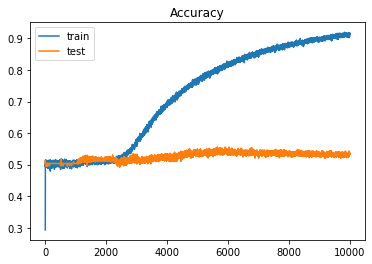

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units=50, dropout_prob=0.5, n_classes=3, epochs=6000, batch_size=32768):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], n_classes))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], n_classes))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    # model.add(Dense(units=1))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc", monitor='val_accuracy', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    # model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train)
    _, test_acc = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled_categorical,
                   X_test_scaled, y_test_scaled_categorical,
                   lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=3,
                   epochs=epochs, batch_size=batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [ ]:
def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [13]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc")

In [14]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [15]:
y_pred = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))

In [16]:
y_test_scaled_categorical, y_pred

(array([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]], dtype=float32),
 array([[3.4336083e-02, 3.2778012e-12, 9.6566397e-01],
        [4.0825835e-01, 2.9987611e-08, 5.9174156e-01],
        [6.2363929e-01, 7.4398914e-09, 3.7636077e-01],
        ...,
        [4.1237831e-02, 2.8753970e-11, 9.5876217e-01],
        [6.8275440e-01, 2.8682484e-08, 3.1724557e-01],
        [6.0336441e-01, 1.2423259e-08, 3.9663559e-01]], dtype=float32))

confusion_matrix: [[791   0 211]
 [  0   0   0]
 [215   0 779]]
acc: 0.7865731462925851
confusion_matrix: [[3254    0  679]
 [   0    0    0]
 [ 835    0 3215]]
acc: 0.8103469873481147


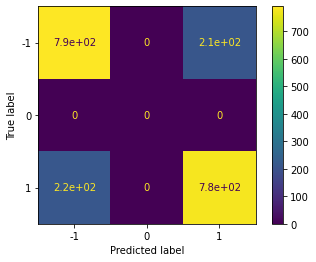

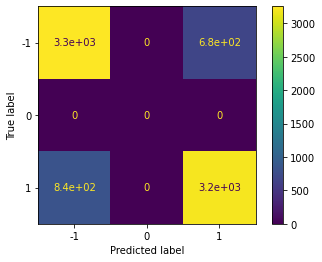

In [17]:
def show_val_res_label(y_true_label, y_pred_label):
    y_true_label = y_true_label - 1
    y_pred_label = y_pred_label - 1
    cm = confusion_matrix(y_true_label, y_pred_label, labels=[-1, 0, 1])
    print('confusion_matrix:', cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()

    acc = accuracy_score(y_true_label, y_pred_label)
    print('acc:', acc)

def show_val_res_categorical(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)
    y_pred_label = np.argmax(y_pred, axis=1)
    show_val_res_label(y_true_label, y_pred_label)

show_val_res_categorical(y_test_scaled_categorical, y_pred)
show_val_res_categorical(y_train_scaled_categorical, lstm_model.predict(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))))

## XGBoost model

### Build model

In [18]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBClassifier

# xgbmodel = XGBClassifier(seed=seed,
#                         n_estimators=n_estimators,
#                         max_depth=max_depth,
#                         learning_rate=learning_rate,
#                         min_child_weight=min_child_weight,
#                         subsample=subsample,
#                         colsample_bytree=colsample_bytree,
#                         colsample_bylevel=colsample_bylevel,
#                         gamma=gamma)
xgbmodel = XGBClassifier()

### Train the model

In [19]:
xgbmodel.fit(X_train_scaled, y_train_scaled_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Test model

In [20]:
y_pred = xgbmodel.predict(X_test_scaled)

confusion_matrix: [[454   0 548]
 [  0   0   0]
 [417   0 577]]
acc: 0.5165330661322646


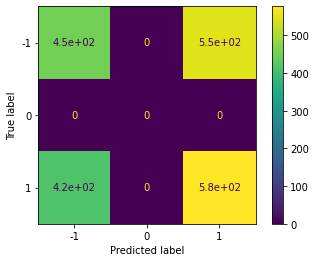

In [21]:
show_val_res_label(y_test_scaled_label, y_pred)